In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
x = np.arange (-1, 1, 0.01)

#Y1 = st.beta(a = 2,b=5,loc=-1,scale=2)
Y1 = st.beta(a = 2,b=5,loc=-1,scale=2)

In [3]:
samples = Y1.rvs(50)
N_SAMPLES = 5000
sample_min = np.min(samples)
sample_max = np.max(samples)

In [4]:
with pm.Model() as beta_model:
    #mu = pm.Uniform('mu',lower=0.0, upper=1.0)
    #sigma_upper = np.sqrt(mu*(1-mu))
    #sigma = pm.Uniform('sigma',lower=0,upper=sigma_upper)
    #observed = pm.Beta('obs',mu=mu,sd=sigma,observed=standard)
    alpha_dist = pm.Gamma('alpha',alpha=7.5,beta=0.5)
    beta_dist = pm.Gamma('beta',alpha=3.0,beta=0.5)
    min_sample = pm.InverseGamma('min',alpha=3.0)
    max_sample = pm.InverseGamma('max',alpha=3.0)
    
    loc = sample_min - min_sample
    scale = (sample_max + max_sample) - (sample_min-min_sample)
    standard = (samples - loc)/scale
    observed = pm.Beta('obs',alpha=alpha_dist,beta=beta_dist,
                         observed=standard)
    map_estimate = pm.find_MAP(model=beta_model)

    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    beta_trace = pm.sample(5000, step=step, njobs=2);

logp = 59.998, ||grad|| = 146.86: 100%|██████████| 28/28 [00:00<00:00, 929.61it/s]   
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [max]
>Metropolis: [min]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 5500/5500 [00:11<00:00, 462.29it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
# Extract the alpha and beta samples
alpha_samples = beta_trace["min"][5000:, None]
beta_samples = beta_trace["max"][5000:, None]

In [6]:
map_estimate

{'alpha': array(inf),
 'alpha_log__': array(2831.43925697),
 'beta': array(0.),
 'beta_log__': array(-1613.31645125),
 'max': array(0.),
 'max_log__': array(-2206.48243755),
 'min': array(inf),
 'min_log__': array(2949.14462271)}

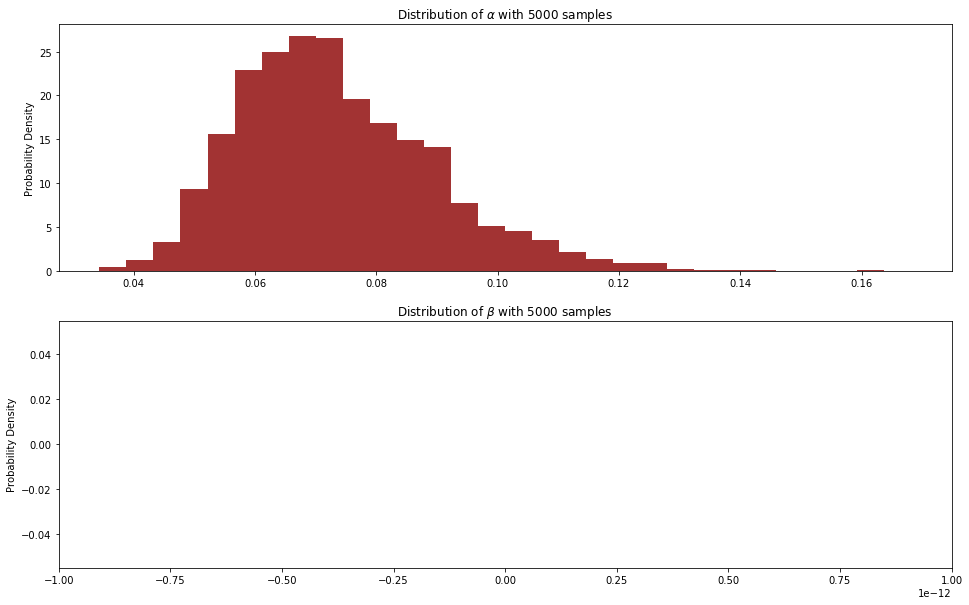

In [7]:
plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

In [ ]:
print(alpha_samples.mean())
beta_samples.mean()

In [ ]:
mu_est = alpha_samples.mean()
sigma_est = beta_samples.mean()

In [ ]:
kappa = mu_est*(1-mu_est)/sigma_est**2 - 1
alpha = mu_est*kappa
beta = (1-mu_est)*kappa

In [ ]:
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)
plt.plot(x,st.beta(alpha_samples.mean(),beta_samples.mean(),loc=-1,scale=2).pdf(x))

In [ ]:
beta